This notebook is designed to forecast electricity usage using time series forecasting and machine learning techniques

1. Import Libraries

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

from prophet import Prophet

2. Load data

In [14]:
with open("household_power_consumption.txt") as f:
    print(f.readline())

df = pd.read_csv(
    "household_power_consumption.txt",
    sep=';',
    parse_dates={'Datetime': ['Date', 'Time']},
    infer_datetime_format=True,
    na_values=['?'],
    low_memory=False
)

print(df.head())

Date;Time;Global_active_power;Global_reactive_power;Voltage;Global_intensity;Sub_metering_1;Sub_metering_2;Sub_metering_3



C:\Users\arifu\AppData\Local\Temp\ipykernel_16496\2622700695.py:4: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv(
C:\Users\arifu\AppData\Local\Temp\ipykernel_16496\2622700695.py:4: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(


             Datetime  Global_active_power  Global_reactive_power  Voltage  \
0 2006-12-16 17:24:00                4.216                  0.418   234.84   
1 2006-12-16 17:25:00                5.360                  0.436   233.63   
2 2006-12-16 17:26:00                5.374                  0.498   233.29   
3 2006-12-16 17:27:00                5.388                  0.502   233.74   
4 2006-12-16 17:28:00                3.666                  0.528   235.68   

   Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
0              18.4             0.0             1.0            17.0  
1              23.0             0.0             1.0            16.0  
2              23.0             0.0             2.0            17.0  
3              23.0             0.0             1.0            17.0  
4              15.8             0.0             1.0            17.0  


C:\Users\arifu\AppData\Local\Temp\ipykernel_16496\2622700695.py:4: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv(


3. Clean data and resample to hourly frequency so it's easier to process

In [ ]:

for col in df.columns:
    if col != 'Datetime': # Converts all columns except 'Datetime' to numeric
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop rows with NaN values
df.dropna(inplace=True)


df.set_index('Datetime', inplace=True)

df_hourly = df.resample('H').mean()

C:\Users\arifu\AppData\Local\Temp\ipykernel_16496\290305126.py:11: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df.resample('H').mean()


4. Prepare dataset for forecasting and target variables

In [ ]:
# Shift target variable (next hour's Global_active_power)
df_hourly['Target'] = df_hourly['Global_active_power'].shift(-1)
df_hourly.dropna(inplace=True) 

X = df_hourly.drop(columns=['Target'])
y = df_hourly['Target']

# no shuffle for time series
X_train, X_test, y_train, y_test = train_test_split(
    X, y, shuffle=False, test_size=0.2)

5. We can also explain patterns in the model inputs using a heatmap and ensure that the features within the dataset correlate in an expected way.

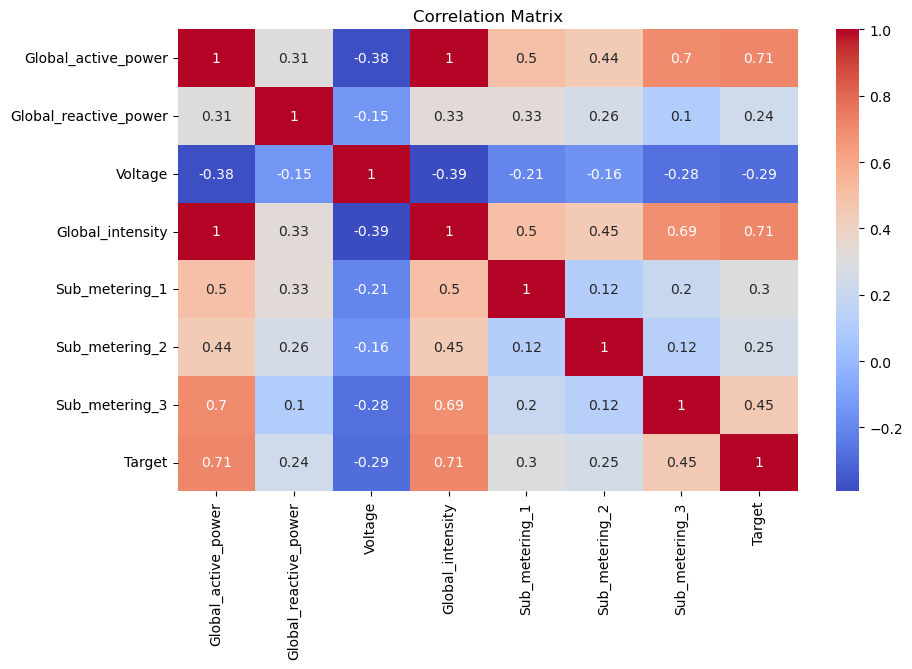

In [27]:
plt.figure(figsize=(10,6))
sns.heatmap(df_hourly.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


From the plot above it can be seen that voltage has a negative correlation with power and intensity which makes sense since intensity = power / voltage. The sub meterings all have a positive correlation with power with metering 3 being the highest and it represents the air con and water heater therefore it will require the most power.

6. Train Random Forest model

In [17]:

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


7. Make predictions and demonstrate values using that model

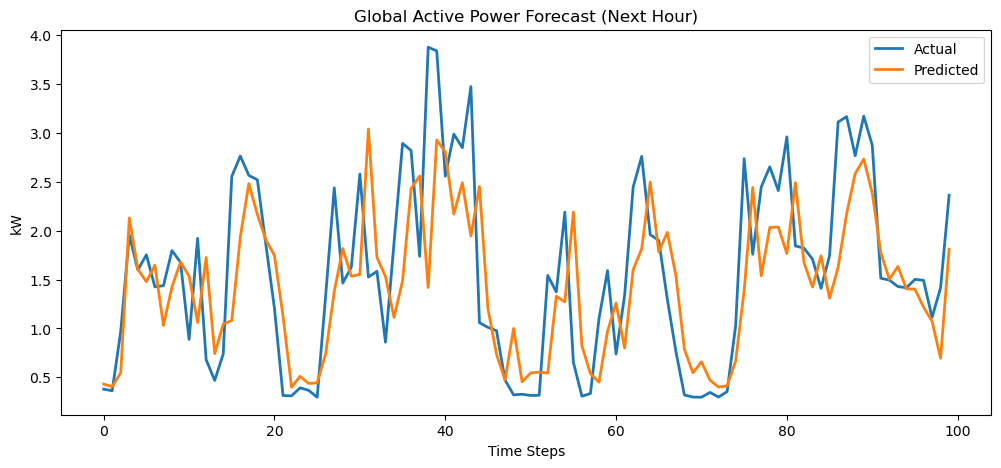

In [31]:
y_pred = model.predict(X_test)

# plot actual vs predicted values
plt.figure(figsize=(12, 5))
plt.plot(y_test.values[:100], label='Actual', linewidth=2)
plt.plot(y_pred[:100], label='Predicted', linewidth=2)
plt.title('Global Active Power Forecast (Next Hour)')
plt.xlabel('Time Steps')
plt.ylabel('kW')
plt.legend()
plt.show()


We can see from the graph that the predicted forecast very closely matches the actual forecast for the hour. This makes the model accurate and that is further influenced by the MAE and RMSE. With a larger time range this could allow the model to be tested more rigorously.

From the trend it is clear that prophet would be better suited to the data because this shows season trends and prophet is designed to work in this type of time series forcasting

8. Make a feature importance to show which details were most important to the model.

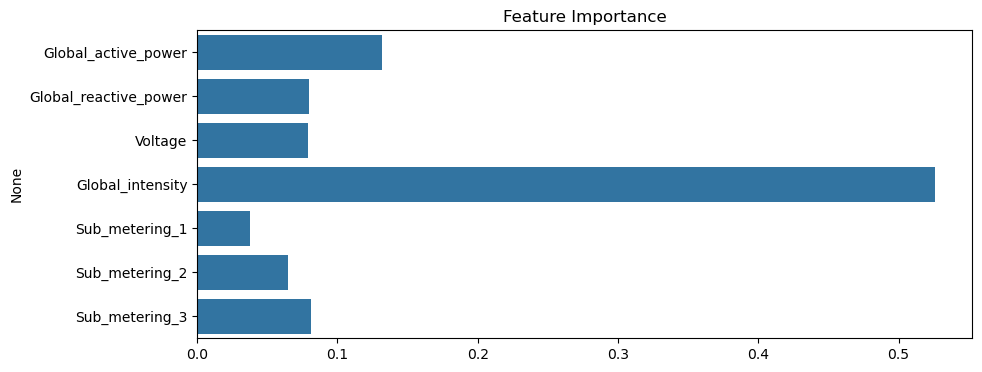

In [19]:
plt.figure(figsize=(10, 4))
sns.barplot(x=model.feature_importances_, y=X.columns)
plt.title("Feature Importance")
plt.show()

From here Global_intensity emerged as the most influential predictor for forecasting the next hour's Global Active Power. This makes sense because it relates to the overall electrical current flowing through the household, which is closely linked to power consumption.

Global_active_power also contributed significantly, showing that recent power consumption levels are valuable indicators for short-term forecasting.


9. Create the prophet model and show the forecast

15:32:25 - cmdstanpy - INFO - Chain [1] start processing
15:32:34 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\arifu\miniforge3\envs\ml-env\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


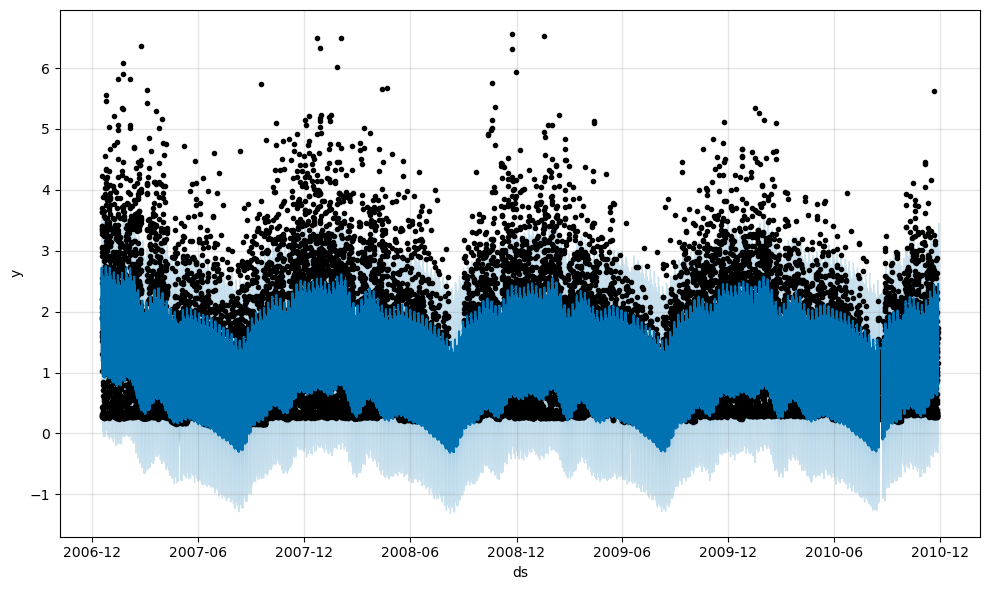

In [ ]:

df_prophet = df_hourly.reset_index()[['Datetime', 'Global_active_power']].rename(
    columns={'Datetime': 'ds', 'Global_active_power': 'y'} # ds as date and y as target variable
)

# Initalises and fits prophet model
prophet_model = Prophet() 
prophet_model.fit(df_prophet)

# Creates a 'future' dataframe for predictions over the next 24hrs
future = prophet_model.make_future_dataframe(periods=24, freq='H')


forecast = prophet_model.predict(future)
plot = prophet_model.plot(forecast)

From here it can be seen that prophet is strongly picking up the seasonality. The band is also narrow suggesting the model is accurate and is able to focus more clearly on the trend rather than show skew.

10. A further comparison of randomforestregressor and prophet can be made by showing their mae and rmse

In [ ]:
# Random Forest errors
rf_mae = mean_absolute_error(y_test, y_pred)
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Prophet: Compare only the last 24 hours of known data
actual = df_prophet['y'][-24:].values
predicted = forecast['yhat'][-48:-24].values

prophet_mae = mean_absolute_error(actual, predicted)
prophet_rmse = np.sqrt(mean_squared_error(actual, predicted))

# Comparison table
comparison_df = pd.DataFrame({
    'Model': ['Random Forest', 'Prophet'],
    'MAE': [rf_mae, prophet_mae],
    'RMSE': [rf_rmse, prophet_rmse]
})

print("Model Performance Comparison:")
print(comparison_df.to_string(index=False))


Model Performance Comparison:
        Model      MAE     RMSE
Random Forest 0.392334 0.542812
      Prophet 0.370244 0.486785


While the Random Forest model captures short-term fluctuations well, Prophet provides better RMSE and MAE in this case. More importantly, Prophet offers the ability to forecast beyond the training window by learning seasonal and trend components in the time series. This makes Prophet essential for long-term planning and pattern decomposition, especially in energy forecasting where demand follows strong cyclical trends (e.g., hourly and daily peaks).

11. Lastly, we can examine seasonality trends of different time frames from the prophet model.

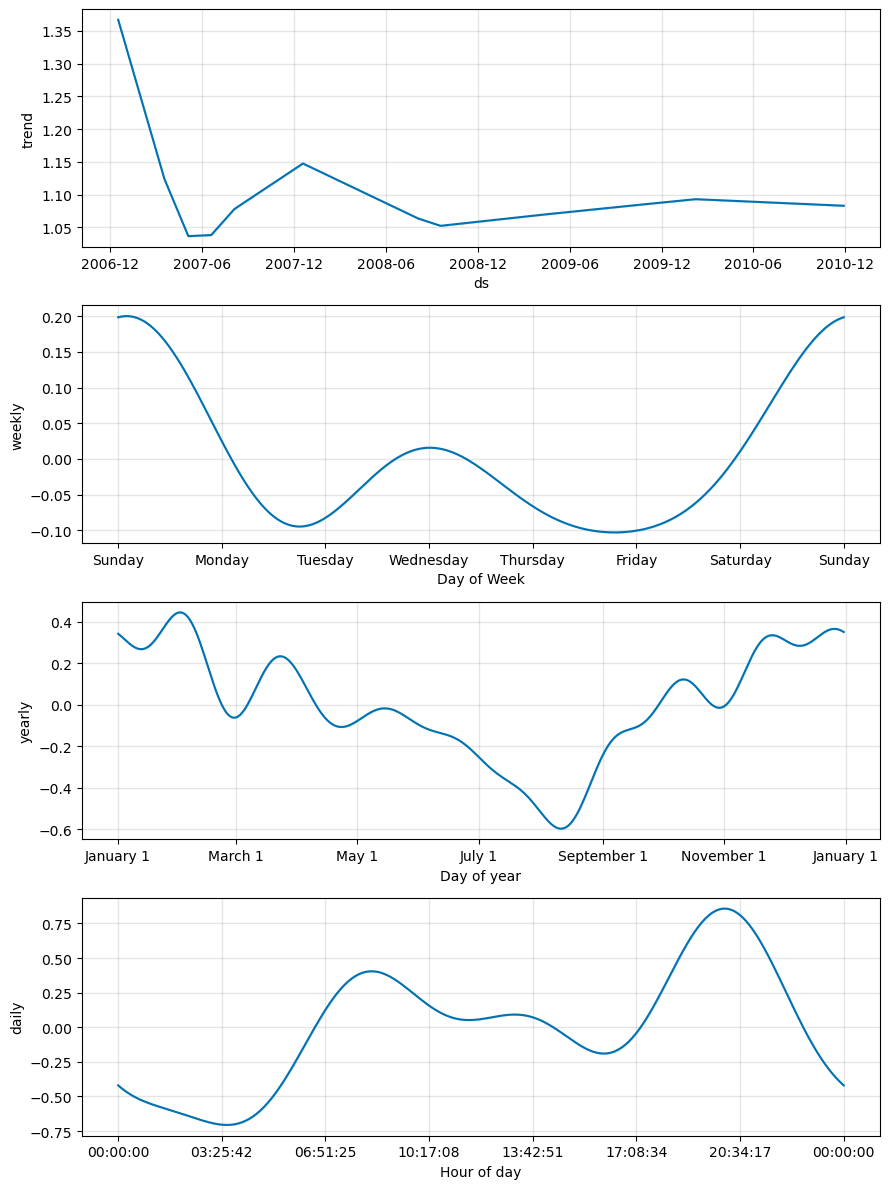

In [ ]:
# Plots hourly, daily, weekly and monthly seasonality trends
prophet_model.plot_components(forecast)
plt.tight_layout()
plt.show()


From the trends above we can see that energy is required more often an night, on weekends and in colder times of the year which matches with a real-life perception of energy use and this shows the utility of prophet even more.